In [15]:
!pip install -q numpy matplotlib scikit-learn

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from indexer import InvertedIndex
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [31]:
def build_tfidf_matrix(index):
    vocab = list(index.postings.keys())
    vocab_index = {tok: i for i, tok in enumerate(vocab)}
    
    doc_ids = list(index.docs.keys())
    doc_index = {doc_id: i for i, doc_id in enumerate(doc_ids)}
    
    tf_matrix = np.zeros((len(doc_ids), len(vocab)), dtype=float)
    
    for tok, postings in index.postings.items():
        for doc_id, freq in postings.items():
            tf_matrix[doc_index[doc_id], vocab_index[tok]] = freq

    df = np.count_nonzero(tf_matrix > 0, axis=0)
    idf = np.log((1 + len(doc_ids)) / (1 + df)) + 1
    tfidf = tf_matrix * idf
    tfidf = normalize(tfidf, norm='l2', axis=1)

    return tfidf, doc_ids, vocab



def get_collection_tfidf(index):
    all_tfidf, all_doc_ids, vocab = build_tfidf_matrix(index)

    doc_indices = [all_doc_ids.index(doc_id) for doc_id in index.my_collection if doc_id in all_doc_ids]
    tfidf_subset = all_tfidf[doc_indices, :]
    selected_docs = [all_doc_ids[i] for i in doc_indices]
    
    return tfidf_subset, selected_docs, vocab




def cluster_documents(tfidf_matrix, doc_ids, n_clusters=5, index=None,  top_50=False):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)

    if not top_50:
        print("\nDocument Clustering Results:")
        for doc_id, label in zip(doc_ids, labels):
            print(f"  Document {doc_id} → Cluster {label} -> {index.docs[doc_id]['url']}")

    return labels

In [29]:
def plot_clusters(tfidf_matrix, labels, k, val):
    reducer = PCA(n_components=2, random_state=42)
    reduced = reducer.fit_transform(tfidf_matrix)

    plt.figure(figsize=(5, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=50)

    plt.title(f'K={k} for {val}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster ID')
    plt.show()


In [24]:
index = InvertedIndex()
index.load("./index.json")

docs_sustainability = index.get_postings("sustainability")
docs_waste = index.get_postings("waste")

n_sustainability = len(docs_sustainability)
n_waste = len(docs_waste)
overlap = len(set(docs_sustainability) & set(docs_waste))

print(f"Documents for 'sustainability': {n_sustainability} - {docs_sustainability}")
print(f"Documents for 'waste': {n_waste} - {docs_waste}")
print(f"Documents in both: {overlap} - {set(docs_sustainability) & set(docs_waste)}")

index.my_collection = list(set(docs_sustainability) | set(docs_waste))
print(f"Total unique documents in My-collection: {len(index.my_collection)} - {index.my_collection}")

Documents for 'sustainability': 23 - {'60': 1, '66': 9, '74': 1, '77': 1, '80': 5, '81': 3, '92': 6, '96': 1, '101': 1, '102': 3, '104': 5, '106': 2, '109': 2, '115': 5, '117': 4, '120': 6, '313': 1, '645': 1, '680': 1, '780': 1, '784': 1, '841': 1, '982': 1}
Documents for 'waste': 18 - {'60': 1, '66': 1, '71': 1, '80': 7, '81': 1, '82': 2, '89': 1, '94': 1, '96': 2, '102': 4, '106': 1, '109': 1, '110': 2, '115': 1, '117': 1, '120': 3, '500': 1, '912': 1}
Documents in both: 11 - {'81', '120', '60', '106', '80', '117', '109', '96', '102', '115', '66'}
Total unique documents in My-collection: 30 - ['110', '841', '80', '77', '784', '71', '912', '102', '92', '982', '66', '120', '313', '500', '94', '109', '96', '101', '60', '89', '117', '680', '82', '780', '104', '115', '74', '81', '645', '106']


Clustering with K=2

Document Clustering Results:
  Document 110 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/1973.html
  Document 841 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creators/Al-Sakkaf=3AAbobakr=3A=3A.html
  Document 80 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/2023.html
  Document 77 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/1997.html
  Document 784 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creators/Adesina=3AAdeyemi_Damilare=3A=3A.html
  Document 71 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/1980.html
  Document 912 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creators/Alimahmoodi=3AMahmood=3A=3A.html
  Document 102 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/2018.html
  Document 92 → Cluster 0 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 982 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creat

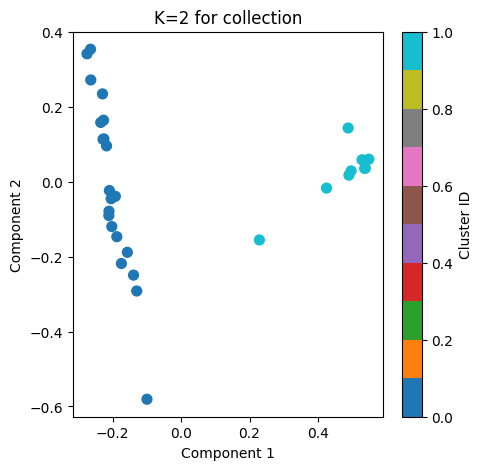

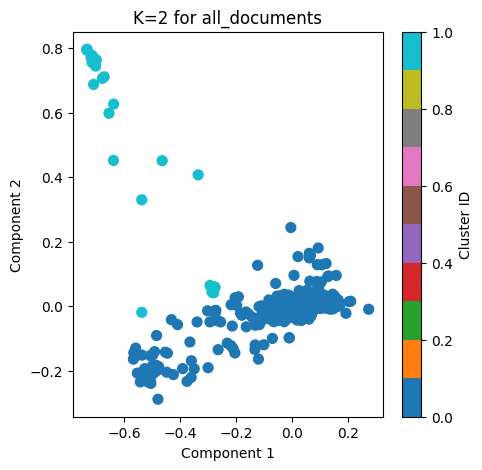

Clustering with K=10

Document Clustering Results:
  Document 110 → Cluster 3 -> https://spectrum.library.concordia.ca/view/year/1973.html
  Document 841 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creators/Al-Sakkaf=3AAbobakr=3A=3A.html
  Document 80 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2023.html
  Document 77 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/1997.html
  Document 784 → Cluster 6 -> https://spectrum.library.concordia.ca/view/creators/Adesina=3AAdeyemi_Damilare=3A=3A.html
  Document 71 → Cluster 4 -> https://spectrum.library.concordia.ca/view/year/1980.html
  Document 912 → Cluster 1 -> https://spectrum.library.concordia.ca/view/creators/Alimahmoodi=3AMahmood=3A=3A.html
  Document 102 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2018.html
  Document 92 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 982 → Cluster 1 -> https://spectrum.library.concordia.ca/view/crea

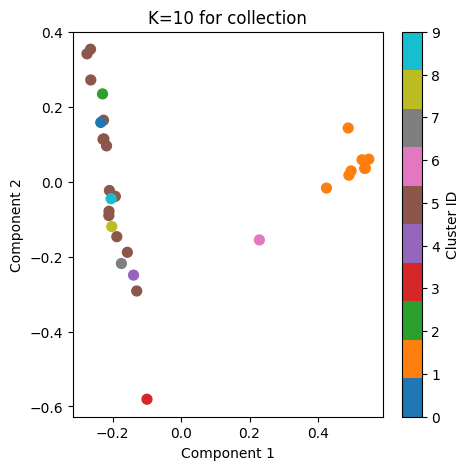

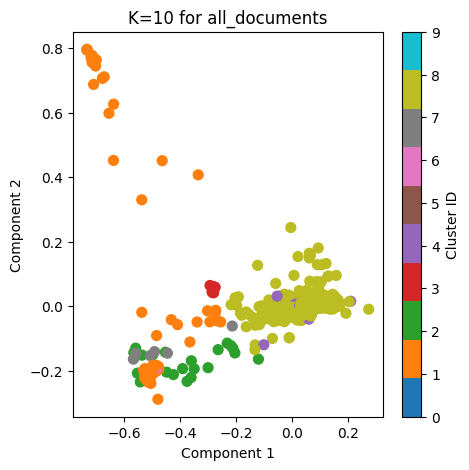

Clustering with K=20

Document Clustering Results:
  Document 110 → Cluster 3 -> https://spectrum.library.concordia.ca/view/year/1973.html
  Document 841 → Cluster 13 -> https://spectrum.library.concordia.ca/view/creators/Al-Sakkaf=3AAbobakr=3A=3A.html
  Document 80 → Cluster 17 -> https://spectrum.library.concordia.ca/view/year/2023.html
  Document 77 → Cluster 10 -> https://spectrum.library.concordia.ca/view/year/1997.html
  Document 784 → Cluster 6 -> https://spectrum.library.concordia.ca/view/creators/Adesina=3AAdeyemi_Damilare=3A=3A.html
  Document 71 → Cluster 4 -> https://spectrum.library.concordia.ca/view/year/1980.html
  Document 912 → Cluster 15 -> https://spectrum.library.concordia.ca/view/creators/Alimahmoodi=3AMahmood=3A=3A.html
  Document 102 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2018.html
  Document 92 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 982 → Cluster 13 -> https://spectrum.library.concordia.ca/view

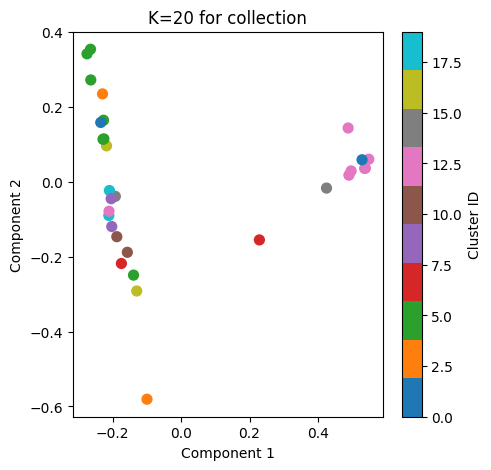

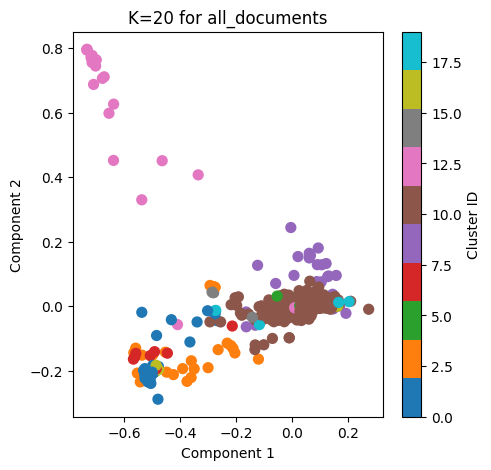

In [30]:
tfidf, doc_ids, vocab = get_collection_tfidf(index)
all_tfidf, all_doc_ids, vocab = build_tfidf_matrix(index)

for k in [2,10,20]:
    print(f"Clustering with K={k}")
    labels = cluster_documents(tfidf, doc_ids, n_clusters=k, index=index)
    labels_for_all  = cluster_documents(all_tfidf, all_doc_ids, n_clusters=k, index=index)
    plot_clusters(tfidf, labels, k, "collection")
    plot_clusters(all_tfidf, labels_for_all, k, "all_documents")

In [ ]:
def top_50_tfidf(tfidf_matrix, labels, index):
    vocab = list(index.postings.keys())
    n_clusters = len(set(labels))
    print("\nTop 50 words per cluster (by TF-IDF)")

    for cluster_id in range(n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            print(f"\nCluster {cluster_id} is empty.")
            continue
        
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
        
        top_indices = np.argsort(-cluster_tfidf)[:50]
        top_words = [(vocab[i], cluster_tfidf[i]) for i in top_indices]

        print(f"\nCluster {cluster_id} ({len(cluster_indices)} docs):")
        for word, score in top_words:
            print(f"  {word:20s}  TF-IDF={score:.4f}")

In [32]:
for k in [2,10,20]:
    print(f"\nClustering with K={k}")
    labels = cluster_documents(tfidf, doc_ids, n_clusters=k, index=index, top_50=True)
    top_50_tfidf(tfidf, labels, index)


Clustering with K=2

Top 50 words per cluster (by TF-IDF)

Cluster 0 (21 docs):
  masters               TF-IDF=0.1819
  thesis                TF-IDF=0.1720
  university            TF-IDF=0.1684
  concordia             TF-IDF=0.1663
  of                    TF-IDF=0.1550
  and                   TF-IDF=0.1450
  the                   TF-IDF=0.1066
  phd                   TF-IDF=0.0958
  in                    TF-IDF=0.0867
  org                   TF-IDF=0.0747
  0000                  TF-IDF=0.0700
  a                     TF-IDF=0.0634
  issn                  TF-IDF=0.0535
  pp                    TF-IDF=0.0528
  orcid                 TF-IDF=0.0478
  0002                  TF-IDF=0.0449
  for                   TF-IDF=0.0444
  2003                  TF-IDF=0.0413
  1981                  TF-IDF=0.0413
  2015                  TF-IDF=0.0408
  2014                  TF-IDF=0.0408
  2010                  TF-IDF=0.0408
  1997                  TF-IDF=0.0408
  2009                  TF-IDF=0.0407
  1980 